# Spektral Library Installation

In [79]:
!pip install spektral

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Libraries and Modules Import

In [80]:
import numpy as np
import pandas as pd
import networkx as nx
from spektral.data import Dataset, Graph
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
from spektral.models.gcn import GCN
from scipy.sparse import csr_matrix
from sklearn.model_selection import train_test_split
from spektral.data.loaders import SingleLoader
from sklearn.preprocessing import MinMaxScaler
from IPython.display import display
import matplotlib.pyplot as plt
plt.style.use('Solarize_Light2')

# Function that Trains and Evaluates a GCN Model Given the Parameters

In [81]:
from keras.backend import dropout
def train_and_evaluate_GCN(G, nodes_attrs, csr_adj_matrix, edges_attrs, labels, learning_rate=1e-2, dropout_rate=0.5, l2_reg=0.00025, epochs=200, patience=20):

    # 1. CONVERT THE GRAPH TO A SPEKTRAL GRAPH DATASET
    class GraphDataset(Dataset):
        def read(self):
            graph = Graph(x=nodes_attrs.to_numpy(), a=csr_adj_matrix, e=edges_attrs.to_numpy(), y=labels)
            return [graph]

    dataset = GraphDataset()

    # 2. SPLIT THE NODES INTO TRAIN, VALIDATION AND TESTS SETS

    node_ids = list(G.nodes)
    train_val_nodes, test_nodes = train_test_split(node_ids, test_size=0.2)
    train_nodes, valid_nodes = train_test_split(train_val_nodes, test_size=0.2)

    # Create masks for the train, validation, and test sets
    train_mask = np.zeros(len(G))
    train_mask[train_nodes] = 1

    valid_mask = np.zeros(len(G))
    valid_mask[valid_nodes] = 1

    test_mask = np.zeros(len(G))
    test_mask[test_nodes] = 1

    # 3. INITIALIZE THE WEIGHTS

    weights = lambda mask : mask.astype(np.float32) / np.count_nonzero(mask)

    weights_tr = weights(train_mask)
    weights_va = weights(valid_mask)
    weights_te = weights(test_mask)

    # 4. INITIALIZE THE LOADERS

    loader_tr = SingleLoader(dataset, sample_weights=weights_tr)
    loader_va = SingleLoader(dataset, sample_weights=weights_va)
    loader_te = SingleLoader(dataset, sample_weights=weights_te)

    # 5. COMPILE THE MODEL

    model = GCN(n_labels=labels.shape[1], dropout_rate=dropout_rate, l2_reg=l2_reg)
    model.compile(
        optimizer=Adam(learning_rate),
        loss=CategoricalCrossentropy(reduction="sum"),
        weighted_metrics=["acc"],
    )

    # 6. TRAIN THE MODEL

    history = model.fit(
        loader_tr.load(),
        steps_per_epoch=loader_tr.steps_per_epoch,
        epochs=epochs,
        validation_data=loader_va,
        validation_steps=loader_va.steps_per_epoch,
        callbacks=[EarlyStopping(monitor='acc', patience=patience, 
                                restore_best_weights=True)],
    )

    # 7. EVALUATE THE MODEL

    print("\nEVALUATING THE MODEL: ")
    eval_results = model.evaluate(loader_te.load(), steps=loader_te.steps_per_epoch)
    print("DONE\n" "TEST LOSS: {}\n" "TEST ACCURACY: {}".format(*eval_results))

    return history


In [82]:
def plot_learning_curves(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    ax1.plot(history.history["loss"], marker='*', linestyle='-', color='dodgerblue')
    ax1.plot(history.history["val_loss"], marker='*', linestyle='-', color='mediumvioletred')
    ax1.legend(["train", "valid"], loc="upper right")
    ax1.set_title('Loss Learning Curve')
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")

    ax2.plot(history.history["acc"], marker='*', linestyle='-', color='dodgerblue')
    ax2.plot(history.history["val_acc"], marker='*', linestyle='-', color='mediumvioletred')
    ax2.legend(["train", "valid"], loc="upper right")
    ax2.set_title('Accuracy Learning Curve')
    ax2.set_xlabel("Epochs")
    ax2.set_ylabel("Accuracy")
    plt.show()

# Node-Level Task to Predict Children's Grade

This graph was generated by including the data of the two days of measurements and then extracting only the stronger edges (those that represented interactions with a duration greater than 2 minutes). Each node is a child and each edge is a cummulative interaction. The relevant nodes attributes are: classroom, grade and gender (this one was not available in our previous analysis). The relevant edges attributes are: count (number of interactions, that is the the edge weight) and duration (cummulative duration of interactions).

## Data Pre-Processing

In [83]:
# 1. LOAD THE GRAPH FROM A GML FILE TO NETWORKX
G = nx.read_gml('graph.gml', label='id')

# 2. DATA PRE-PROCESSING

scaler = MinMaxScaler() # to normalize continuous values

# [EDGES ATTRIBUTES]

edges_attrs = nx.to_pandas_edgelist(G)

# drop attributes we don't need
edges_attrs = edges_attrs.drop('source', axis=1)
edges_attrs = edges_attrs.drop('target', axis=1)
edges_attrs = edges_attrs.drop('id', axis=1)

# normalize continuous values
edges_attrs[['duration', 'count']] = scaler.fit_transform(edges_attrs[['duration', 'count']])
print('EDGES ATTRIBUTES:\n')
display(edges_attrs)

# [NODES ATTRIBUTES AND LABELS]

# we make a dataframe for our nodes: each row is a node, each column is an attribute
nodes_attrs = pd.DataFrame(index=G.nodes())
for attr in ['classroom', 'grade', 'gender']:
    nodes_attrs[attr] = pd.Series(nx.get_node_attributes(G, attr))
nodes_attrs = nodes_attrs.sort_index()

# we apply one-hot encoding to our target attribute: grade
nodes_attrs['grade'] = nodes_attrs['grade'].astype('category')
labels = tf.constant(pd.get_dummies(nodes_attrs['grade']).values.astype(np.float32))

# we drop our target attribute from our nodes attributes dataframe
nodes_attrs = nodes_attrs.drop('grade', axis=1)

print('LABELS:\n')
print(labels)

# we apply one-hot encoding to classroom and gender attribues of our nodes attributes dataframe

# one-hot encoding: classroom
classroom_encoded = pd.get_dummies(nodes_attrs['classroom'], prefix='classroom').astype(np.float32)
nodes_attrs = pd.concat([nodes_attrs, classroom_encoded], axis=1)
nodes_attrs = nodes_attrs.drop('classroom', axis=1)

# one-hot encoding: gender
gender_encoded = pd.get_dummies(nodes_attrs['gender'], prefix='gender').astype(np.float32)
nodes_attrs = pd.concat([nodes_attrs, gender_encoded], axis=1)
nodes_attrs = nodes_attrs.drop('gender', axis=1)

print('\nNODES ATTRIBUTES:\n')
display(nodes_attrs)

# WEIGHTED CSR ADJACENCY MATRIX
adj_matrix = np.zeros((len(G), len(G)))
for u, v, attrs in G.edges(data=True):
    node1, node2 = u, v
    weight = attrs.get("count") # count will be our weight attribute
    adj_matrix[node1][node2] = float(weight)
    adj_matrix[node2][node1] = float(weight)
csr_adj_matrix = csr_matrix(adj_matrix) # to get efficient representation of sparse matrix
print('WEIGHTED CSR ADJACENCY MATRIX:\n')
print(csr_adj_matrix)

EDGES ATTRIBUTES:



,duration,count
0,0.069921,0.069921
1,0.155673,0.155673
2,0.002639,0.002639
3,0.068602,0.068602
4,0.019789,0.019789
...,...,...
3229,0.042216,0.042216
3230,0.047493,0.047493
3231,0.011873,0.011873
3232,0.018470,0.018470


LABELS:

tf.Tensor(
[[0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1. 0.]
 ...
 [0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]], shape=(242, 6), dtype=float32)

NODES ATTRIBUTES:



,classroom_1A,classroom_1B,classroom_2A,classroom_2B,classroom_3A,classroom_3B,classroom_4A,classroom_4B,classroom_5A,classroom_5B,classroom_T,gender_F,gender_M,gender_U
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
237,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
238,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
239,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
240,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


WEIGHTED CSR ADJACENCY MATRIX:

  (0, 1)	27.0
  (0, 2)	45.0
  (0, 3)	75.0
  (0, 4)	19.0
  (0, 5)	43.0
  (0, 6)	8.0
  (0, 7)	12.0
  (0, 8)	23.0
  (0, 9)	27.0
  (0, 10)	8.0
  (0, 11)	44.0
  (0, 13)	11.0
  (0, 17)	13.0
  (0, 19)	12.0
  (0, 20)	51.0
  (0, 21)	59.0
  (0, 22)	9.0
  (0, 23)	11.0
  (0, 25)	16.0
  (0, 26)	23.0
  (0, 28)	124.0
  (0, 29)	7.0
  (0, 32)	58.0
  (0, 38)	11.0
  (0, 41)	24.0
  :	:
  (241, 80)	28.0
  (241, 82)	70.0
  (241, 83)	19.0
  (241, 87)	52.0
  (241, 88)	25.0
  (241, 89)	28.0
  (241, 90)	16.0
  (241, 91)	17.0
  (241, 92)	15.0
  (241, 130)	101.0
  (241, 163)	11.0
  (241, 175)	18.0
  (241, 205)	37.0
  (241, 209)	7.0
  (241, 211)	33.0
  (241, 222)	43.0
  (241, 227)	6.0
  (241, 228)	16.0
  (241, 229)	13.0
  (241, 230)	34.0
  (241, 234)	18.0
  (241, 236)	72.0
  (241, 237)	38.0
  (241, 238)	20.0
  (241, 239)	9.0


## GCN Training and Evaluation

Epoch 1/200
1/1 [==============================] - 2s 2s/step - loss: 221010.6094 - acc: 0.1818 - val_loss: 132791.0625 - val_acc: 0.2308
Epoch 2/200
1/1 [==============================] - 0s 99ms/step - loss: 139623.2031 - acc: 0.3182 - val_loss: 107693.5703 - val_acc: 0.3590
Epoch 3/200
1/1 [==============================] - 0s 90ms/step - loss: 161669.9531 - acc: 0.2597 - val_loss: 98492.5859 - val_acc: 0.4103
Epoch 4/200
1/1 [==============================] - 0s 97ms/step - loss: 133032.6250 - acc: 0.2857 - val_loss: 87449.0859 - val_acc: 0.3846
Epoch 5/200
1/1 [==============================] - 0s 57ms/step - loss: 138712.1562 - acc: 0.3766 - val_loss: 74244.1172 - val_acc: 0.3846
Epoch 6/200
1/1 [==============================] - 0s 55ms/step - loss: 125109.4609 - acc: 0.2922 - val_loss: 59729.4727 - val_acc: 0.4359
Epoch 7/200
1/1 [==============================] - 0s 54ms/step - loss: 103909.1250 - acc: 0.2987 - val_loss: 49031.4570 - val_acc: 0.4615
Epoch 8/200
1/1 [==========

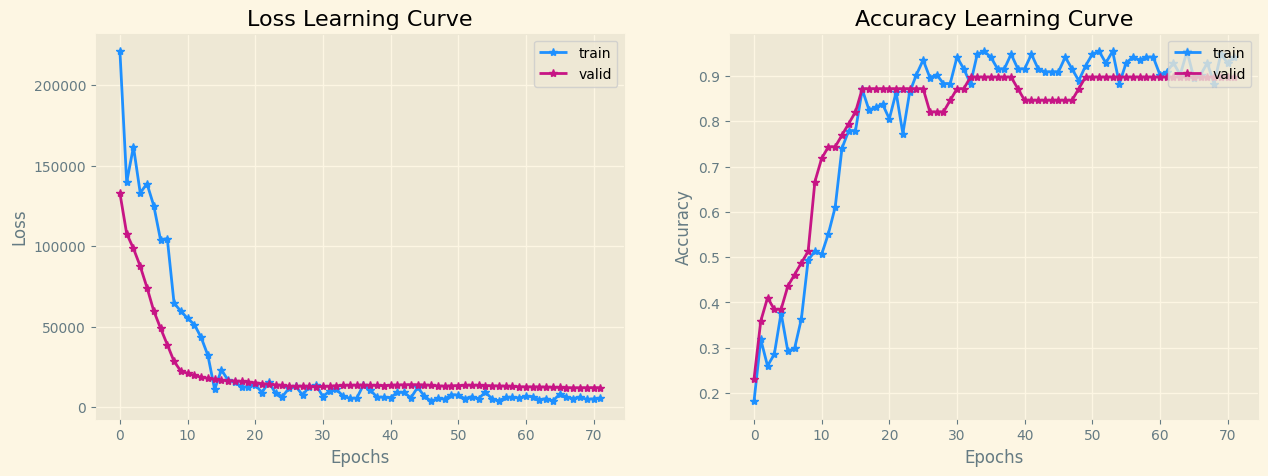

In [84]:
history = train_and_evaluate_GCN(G, nodes_attrs, csr_adj_matrix, edges_attrs, labels)
plot_learning_curves(history)

# Node-Level Task to Predict Children's Classroom

This graph was generated by including the data of the two days of measurements and then extracting only the stronger edges (those that represented interactions with a duration greater than 2 minutes). Each node is a child and each edge is a cummulative interaction. The relevant nodes attributes are: classroom, grade and gender (this one was not available in our previous analysis). The relevant edges attributes are: count (number of interactions, that is the the edge weight) and duration (cummulative duration of interactions).

## Data Pre-Processing

In [85]:
# 1. LOAD THE GRAPH FROM A GML FILE TO NETWORKX
G = nx.read_gml('graph.gml', label='id')

# 2. DATA PRE-PROCESSING

scaler = MinMaxScaler() # to normalize continuous values

# [EDGES ATTRIBUTES]

edges_attrs = nx.to_pandas_edgelist(G)

# drop attributes we don't need
edges_attrs = edges_attrs.drop('source', axis=1)
edges_attrs = edges_attrs.drop('target', axis=1)
edges_attrs = edges_attrs.drop('id', axis=1)

# normalize continuous values
edges_attrs[['duration', 'count']] = scaler.fit_transform(edges_attrs[['duration', 'count']])
print('EDGES ATTRIBUTES:\n')
display(edges_attrs)

# [NODES ATTRIBUTES AND LABELS]

# we make a dataframe for our nodes: each row is a node, each column is an attribute
nodes_attrs = pd.DataFrame(index=G.nodes())
for attr in ['classroom', 'grade', 'gender']:
    nodes_attrs[attr] = pd.Series(nx.get_node_attributes(G, attr))
nodes_attrs = nodes_attrs.sort_index()

# we apply one-hot encoding to our target attribute: classroom
nodes_attrs['classroom'] = nodes_attrs['classroom'].astype('category')
labels = tf.constant(pd.get_dummies(nodes_attrs['classroom']).values.astype(np.float32))

# we drop our target attribute from our nodes attributes dataframe
nodes_attrs = nodes_attrs.drop('classroom', axis=1)

print('LABELS:\n')
print(labels)

# we apply one-hot encoding to classroom and gender attribues of our nodes attributes dataframe

# one-hot encoding: grade
grade_encoded = pd.get_dummies(nodes_attrs['grade'], prefix='grade').astype(np.float32)
nodes_attrs = pd.concat([nodes_attrs, grade_encoded], axis=1)
nodes_attrs = nodes_attrs.drop('grade', axis=1)

# one-hot encoding: gender
gender_encoded = pd.get_dummies(nodes_attrs['gender'], prefix='gender').astype(np.float32)
nodes_attrs = pd.concat([nodes_attrs, gender_encoded], axis=1)
nodes_attrs = nodes_attrs.drop('gender', axis=1)

print('\nNODES ATTRIBUTES:\n')
display(nodes_attrs)

# WEIGHTED CSR ADJACENCY MATRIX
adj_matrix = np.zeros((len(G), len(G)))
for u, v, attrs in G.edges(data=True):
    node1, node2 = u, v
    weight = attrs.get("count") # count will be our weight attribute
    adj_matrix[node1][node2] = float(weight)
    adj_matrix[node2][node1] = float(weight)
csr_adj_matrix = csr_matrix(adj_matrix)
print('WEIGHTED CSR ADJACENCY MATRIX:\n')
print(csr_adj_matrix)

EDGES ATTRIBUTES:



,duration,count
0,0.069921,0.069921
1,0.155673,0.155673
2,0.002639,0.002639
3,0.068602,0.068602
4,0.019789,0.019789
...,...,...
3229,0.042216,0.042216
3230,0.047493,0.047493
3231,0.011873,0.011873
3232,0.018470,0.018470


LABELS:

tf.Tensor(
[[0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 ...
 [0. 0. 1. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]], shape=(242, 11), dtype=float32)

NODES ATTRIBUTES:



,grade_1,grade_2,grade_3,grade_4,grade_5,grade_T,gender_F,gender_M,gender_U
0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
1,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
3,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...
237,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
238,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
239,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
240,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


WEIGHTED CSR ADJACENCY MATRIX:

  (0, 1)	27.0
  (0, 2)	45.0
  (0, 3)	75.0
  (0, 4)	19.0
  (0, 5)	43.0
  (0, 6)	8.0
  (0, 7)	12.0
  (0, 8)	23.0
  (0, 9)	27.0
  (0, 10)	8.0
  (0, 11)	44.0
  (0, 13)	11.0
  (0, 17)	13.0
  (0, 19)	12.0
  (0, 20)	51.0
  (0, 21)	59.0
  (0, 22)	9.0
  (0, 23)	11.0
  (0, 25)	16.0
  (0, 26)	23.0
  (0, 28)	124.0
  (0, 29)	7.0
  (0, 32)	58.0
  (0, 38)	11.0
  (0, 41)	24.0
  :	:
  (241, 80)	28.0
  (241, 82)	70.0
  (241, 83)	19.0
  (241, 87)	52.0
  (241, 88)	25.0
  (241, 89)	28.0
  (241, 90)	16.0
  (241, 91)	17.0
  (241, 92)	15.0
  (241, 130)	101.0
  (241, 163)	11.0
  (241, 175)	18.0
  (241, 205)	37.0
  (241, 209)	7.0
  (241, 211)	33.0
  (241, 222)	43.0
  (241, 227)	6.0
  (241, 228)	16.0
  (241, 229)	13.0
  (241, 230)	34.0
  (241, 234)	18.0
  (241, 236)	72.0
  (241, 237)	38.0
  (241, 238)	20.0
  (241, 239)	9.0


## GCN Training and Evaluation

Epoch 1/200
1/1 [==============================] - 1s 1s/step - loss: 669652.1875 - acc: 0.0455 - val_loss: 338447.3125 - val_acc: 0.0256
Epoch 2/200
1/1 [==============================] - 0s 96ms/step - loss: 478972.6875 - acc: 0.0714 - val_loss: 287893.9062 - val_acc: 0.1282
Epoch 3/200
1/1 [==============================] - 0s 100ms/step - loss: 344459.4062 - acc: 0.1104 - val_loss: 241864.4062 - val_acc: 0.0769
Epoch 4/200
1/1 [==============================] - 0s 56ms/step - loss: 319363.3438 - acc: 0.0844 - val_loss: 197820.6719 - val_acc: 0.0513
Epoch 5/200
1/1 [==============================] - 0s 56ms/step - loss: 253820.1094 - acc: 0.0779 - val_loss: 162229.6875 - val_acc: 0.0769
Epoch 6/200
1/1 [==============================] - 0s 65ms/step - loss: 247449.1562 - acc: 0.0844 - val_loss: 135191.8750 - val_acc: 0.1026
Epoch 7/200
1/1 [==============================] - 0s 56ms/step - loss: 204156.8594 - acc: 0.0844 - val_loss: 111138.4375 - val_acc: 0.1282
Epoch 8/200
1/1 [====

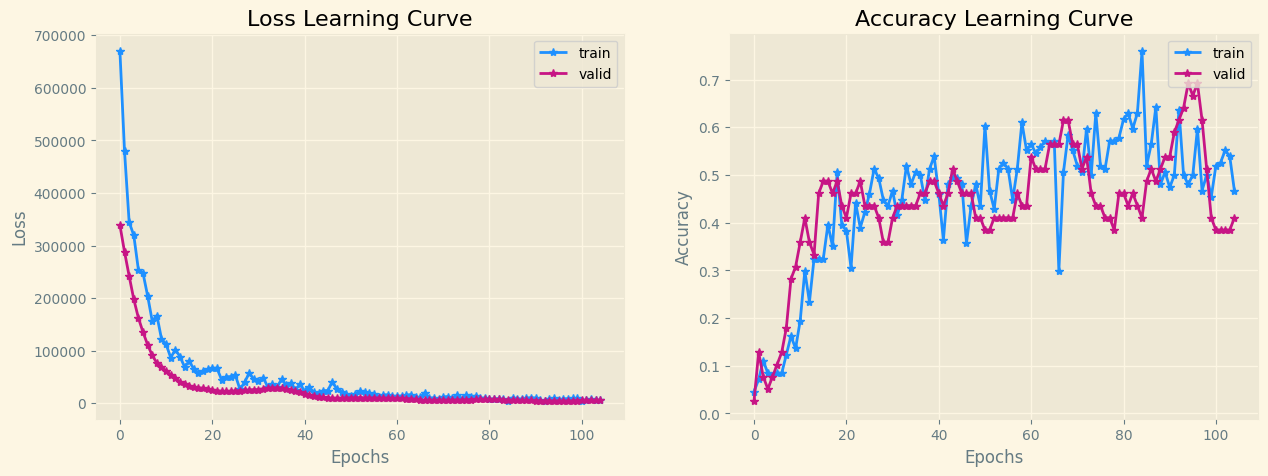

In [86]:
history = train_and_evaluate_GCN(G, nodes_attrs, csr_adj_matrix, edges_attrs, labels)
plot_learning_curves(history)

# Node-Level Task to Predict Children's Community (6)

This graph was generated by including the data of the two days of measurements and then extracting only the stronger edges (those that represented interactions with a duration greater than 2 minutes). After that we applied the Louvain community detection algorithm with a resolution value of 1.0 to get 6 communities. Each node is a child and each edge is a cummulative interaction. The relevant nodes attributes are: classroom, grade, number of contacts, cummulative duration of contacts and community. The relevant edges attributes are: count (number of interactions, that is the the edge weight) and duration (cummulative duration of interactions).

## Data Pre-Processing

In [87]:
# 1. LOAD THE GRAPH FROM A GML FILE TO NETWORKX
G = nx.read_gml('Subgraph_1_6_42.gml', label='id')

# 2. DATA PRE-PROCESSING

scaler = MinMaxScaler() # to normalize continuous values

# [EDGES ATTRIBUTES]

edges_attrs = nx.to_pandas_edgelist(G)

# drop attributes we don't need
edges_attrs = edges_attrs.drop('source', axis=1)
edges_attrs = edges_attrs.drop('target', axis=1)

# normalize continuous values
edges_attrs[['duration', 'count']] = scaler.fit_transform(edges_attrs[['duration', 'count']])
print('EDGES ATTRIBUTES:\n')
display(edges_attrs)

# [NODES ATTRIBUTES AND LABELS]

# we make a dataframe for our nodes: each row is a node, each column is an attribute
nodes_attrs = pd.DataFrame(index=G.nodes())
for attr in ['classroom', 'grade', 'contacts', 'duration', 'community']:
    nodes_attrs[attr] = pd.Series(nx.get_node_attributes(G, attr))
nodes_attrs = nodes_attrs.sort_index()

# we apply one-hot encoding to our target attribute: community
nodes_attrs['community'] = nodes_attrs['community'].astype('category')
labels = tf.constant(pd.get_dummies(nodes_attrs['community']).values.astype(np.float32))

# we drop our target attribute from our nodes attributes dataframe
nodes_attrs = nodes_attrs.drop('community', axis=1)

print('LABELS:\n')
print(labels)

# we apply one-hot encoding to classroom and gender attribues of our nodes attributes dataframe

# one-hot encoding: classroom
classroom_encoded = pd.get_dummies(nodes_attrs['classroom'], prefix='classroom').astype(np.float32)
nodes_attrs = pd.concat([nodes_attrs, classroom_encoded], axis=1)
nodes_attrs = nodes_attrs.drop('classroom', axis=1)

# one-hot encoding: grade
grade_encoded = pd.get_dummies(nodes_attrs['grade'], prefix='grade').astype(np.float32)
nodes_attrs = pd.concat([nodes_attrs, grade_encoded], axis=1)
nodes_attrs = nodes_attrs.drop('grade', axis=1)

# normalize continuous values
nodes_attrs[['contacts', 'duration']] = scaler.fit_transform(nodes_attrs[['contacts', 'duration']])

print('\nNODES ATTRIBUTES:\n')
display(nodes_attrs)

# WEIGHTED CSR ADJACENCY MATRIX
adj_matrix = np.zeros((len(G), len(G)))
for u, v, attrs in G.edges(data=True):
    node1, node2 = u, v
    weight = attrs.get("count") # count will be our weight attribute
    adj_matrix[node1][node2] = float(weight)
    adj_matrix[node2][node1] = float(weight)
csr_adj_matrix = csr_matrix(adj_matrix)
print('WEIGHTED CSR ADJACENCY MATRIX:\n')
print(csr_adj_matrix)

EDGES ATTRIBUTES:



,count,duration
0,0.115646,0.057339
1,0.040816,0.002294
2,0.129252,0.048165
3,0.136054,0.055046
4,0.197279,0.080275
...,...,...
2172,0.034014,0.006881
2173,0.047619,0.018349
2174,0.020408,0.004587
2175,0.115646,0.057339


LABELS:

tf.Tensor(
[[1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 ...
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 1.]], shape=(238, 6), dtype=float32)

NODES ATTRIBUTES:



,contacts,duration,classroom_1stA,classroom_1stB,classroom_2ndA,classroom_2ndB,classroom_3rdA,classroom_3rdB,classroom_4thA,classroom_4thB,classroom_5thA,classroom_5thB,classroom_teachers,grade_1st6,grade_2nd7,grade_3rd8,grade_4th9,grade_5th10,grade_teachers
0,0.632342,0.557224,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,0.558376,0.559659,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,0.852067,0.853896,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,0.881798,0.940341,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,0.295867,0.250406,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
233,0.411893,0.414367,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
234,0.231327,0.273539,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
235,0.280638,0.274756,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
236,0.435098,0.353084,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


WEIGHTED CSR ADJACENCY MATRIX:

  (0, 2)	30.0
  (0, 3)	21.0
  (0, 4)	7.0
  (0, 6)	6.0
  (0, 7)	64.0
  (0, 8)	12.0
  (0, 10)	10.0
  (0, 11)	28.0
  (0, 12)	17.0
  (0, 13)	19.0
  (0, 14)	13.0
  (0, 15)	29.0
  (0, 16)	15.0
  (0, 17)	12.0
  (0, 18)	30.0
  (0, 19)	22.0
  (0, 20)	32.0
  (0, 22)	22.0
  (0, 23)	7.0
  (0, 24)	20.0
  (0, 155)	18.0
  (0, 168)	26.0
  (0, 193)	31.0
  (0, 209)	25.0
  (0, 212)	21.0
  :	:
  (236, 221)	8.0
  (236, 223)	6.0
  (236, 224)	6.0
  (236, 227)	11.0
  (236, 229)	4.0
  (236, 230)	31.0
  (236, 231)	30.0
  (236, 232)	8.0
  (236, 233)	41.0
  (236, 235)	4.0
  (236, 237)	6.0
  (237, 195)	5.0
  (237, 208)	5.0
  (237, 209)	25.0
  (237, 211)	53.0
  (237, 212)	11.0
  (237, 213)	19.0
  (237, 218)	13.0
  (237, 220)	16.0
  (237, 221)	8.0
  (237, 227)	5.0
  (237, 231)	27.0
  (237, 234)	8.0
  (237, 235)	18.0
  (237, 236)	6.0


## GCN Training and Evaluation

Epoch 1/200
1/1 [==============================] - 2s 2s/step - loss: 47197.3633 - acc: 0.1974 - val_loss: 39558.8516 - val_acc: 0.1316
Epoch 2/200
1/1 [==============================] - 0s 88ms/step - loss: 42196.4297 - acc: 0.0855 - val_loss: 31530.1660 - val_acc: 0.1053
Epoch 3/200
1/1 [==============================] - 0s 91ms/step - loss: 24412.0176 - acc: 0.1645 - val_loss: 24772.5645 - val_acc: 0.1316
Epoch 4/200
1/1 [==============================] - 0s 134ms/step - loss: 21897.6055 - acc: 0.1579 - val_loss: 19302.4980 - val_acc: 0.1316
Epoch 5/200
1/1 [==============================] - 0s 96ms/step - loss: 23977.0332 - acc: 0.1447 - val_loss: 15872.0117 - val_acc: 0.1316
Epoch 6/200
1/1 [==============================] - 0s 99ms/step - loss: 10959.8369 - acc: 0.3421 - val_loss: 13070.7402 - val_acc: 0.1316
Epoch 7/200
1/1 [==============================] - 0s 74ms/step - loss: 8009.4829 - acc: 0.3026 - val_loss: 10650.7842 - val_acc: 0.2105
Epoch 8/200
1/1 [===================

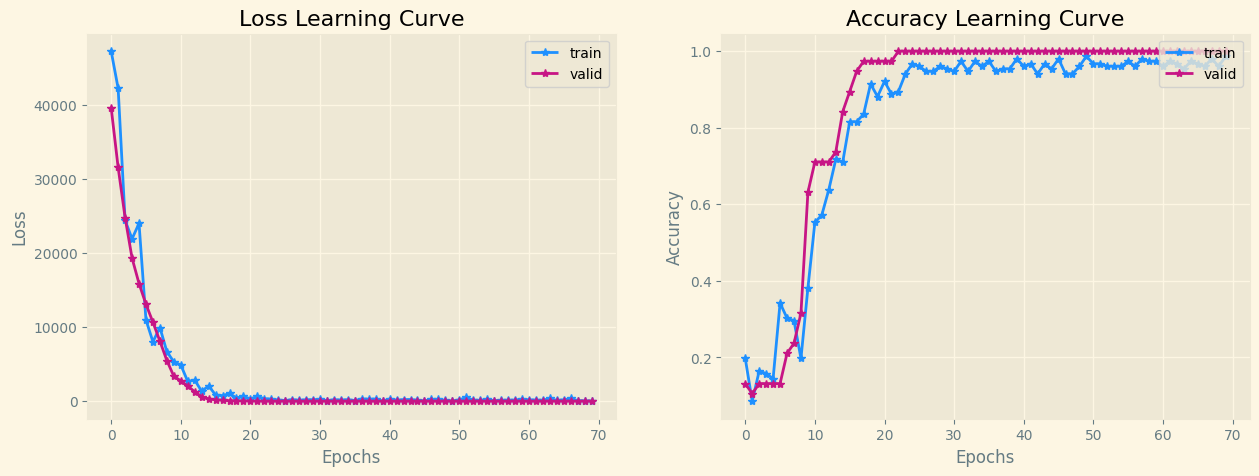

In [88]:
history = train_and_evaluate_GCN(G, nodes_attrs, csr_adj_matrix, edges_attrs, labels)
plot_learning_curves(history)

# Node-Level Task to Predict Children's Community (10)

This graph was generated by including the data of the two days of measurements and then extracting only the stronger edges (those that represented interactions with a duration greater than 2 minutes). After that we applied the Louvain community detection algorithm with a resolution value of 2.0 to get 10 communities. Each node is a child and each edge is a cummulative interaction. The relevant nodes attributes are: classroom, grade, number of contacts, cummulative duration of contacts and community. The relevant edges attributes are: count (number of interactions, that is the the edge weight) and duration (cummulative duration of interactions).

## Data Pre-Processing

In [89]:
# 1. LOAD THE GRAPH FROM A GML FILE TO NETWORKX
G = nx.read_gml('Subgraph_2_10_42.gml', label='id')

# 2. DATA PRE-PROCESSING

scaler = MinMaxScaler() # to normalize continuous values

# [EDGES ATTRIBUTES]

edges_attrs = nx.to_pandas_edgelist(G)

# drop attributes we don't need
edges_attrs = edges_attrs.drop('source', axis=1)
edges_attrs = edges_attrs.drop('target', axis=1)

# normalize continuous values
edges_attrs[['duration', 'count']] = scaler.fit_transform(edges_attrs[['duration', 'count']])
print('EDGES ATTRIBUTES:\n')
display(edges_attrs)

# [NODES ATTRIBUTES AND LABELS]

# we make a dataframe for our nodes: each row is a node, each column is an attribute
nodes_attrs = pd.DataFrame(index=G.nodes())
for attr in ['classroom', 'grade', 'contacts', 'duration', 'community']:
    nodes_attrs[attr] = pd.Series(nx.get_node_attributes(G, attr))
nodes_attrs = nodes_attrs.sort_index()

# we apply one-hot encoding to our target attribute: community
nodes_attrs['community'] = nodes_attrs['community'].astype('category')
labels = tf.constant(pd.get_dummies(nodes_attrs['community']).values.astype(np.float32))

# we drop our target attribute from our nodes attributes dataframe
nodes_attrs = nodes_attrs.drop('community', axis=1)

print('LABELS:\n')
print(labels)

# we apply one-hot encoding to classroom and gender attribues of our nodes attributes dataframe

# one-hot encoding: classroom
classroom_encoded = pd.get_dummies(nodes_attrs['classroom'], prefix='classroom').astype(np.float32)
nodes_attrs = pd.concat([nodes_attrs, classroom_encoded], axis=1)
nodes_attrs = nodes_attrs.drop('classroom', axis=1)

# one-hot encoding: grade
grade_encoded = pd.get_dummies(nodes_attrs['grade'], prefix='grade').astype(np.float32)
nodes_attrs = pd.concat([nodes_attrs, grade_encoded], axis=1)
nodes_attrs = nodes_attrs.drop('grade', axis=1)

# normalize continuous values
nodes_attrs[['contacts', 'duration']] = scaler.fit_transform(nodes_attrs[['contacts', 'duration']])

print('\nNODES ATTRIBUTES:\n')
display(nodes_attrs)

# WEIGHTED CSR ADJACENCY MATRIX
adj_matrix = np.zeros((len(G), len(G)))
for u, v, attrs in G.edges(data=True):
    node1, node2 = u, v
    weight = attrs.get("count") # count will be our weight attribute
    adj_matrix[node1][node2] = float(weight)
    adj_matrix[node2][node1] = float(weight)
csr_adj_matrix = csr_matrix(adj_matrix)
print('WEIGHTED CSR ADJACENCY MATRIX:\n')
print(csr_adj_matrix)

EDGES ATTRIBUTES:



,count,duration
0,0.496599,0.302752
1,0.251701,0.149083
2,0.068027,0.018349
3,0.040816,0.004587
4,0.034014,0.004587
...,...,...
2172,0.034014,0.000000
2173,0.074830,0.061927
2174,0.054422,0.016055
2175,0.034014,0.004587


LABELS:

tf.Tensor(
[[1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]], shape=(238, 10), dtype=float32)

NODES ATTRIBUTES:



,contacts,duration,classroom_1stA,classroom_1stB,classroom_2ndA,classroom_2ndB,classroom_3rdA,classroom_3rdB,classroom_4thA,classroom_4thB,classroom_5thA,classroom_5thB,classroom_teachers,grade_1st6,grade_2nd7,grade_3rd8,grade_4th9,grade_5th10,grade_teachers
0,0.425671,0.409903,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,0.277737,0.276786,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,0.306744,0.269075,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,0.426396,0.480114,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,0.058738,0.104708,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
233,0.193619,0.157873,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
234,0.013778,0.047484,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
235,0.374184,0.315747,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
236,0.432922,0.409497,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


WEIGHTED CSR ADJACENCY MATRIX:

  (0, 1)	74.0
  (0, 2)	38.0
  (0, 3)	11.0
  (0, 5)	6.0
  (0, 6)	16.0
  (0, 7)	43.0
  (0, 8)	13.0
  (0, 9)	19.0
  (0, 10)	25.0
  (0, 11)	4.0
  (0, 12)	15.0
  (0, 13)	14.0
  (0, 14)	12.0
  (0, 15)	10.0
  (0, 16)	13.0
  (0, 17)	35.0
  (0, 18)	22.0
  (0, 19)	10.0
  (0, 20)	6.0
  (0, 70)	20.0
  (0, 86)	36.0
  (0, 100)	7.0
  (0, 110)	14.0
  (0, 123)	9.0
  (0, 126)	4.0
  :	:
  (236, 225)	8.0
  (236, 232)	6.0
  (236, 237)	28.0
  (237, 28)	13.0
  (237, 34)	10.0
  (237, 36)	4.0
  (237, 41)	8.0
  (237, 44)	31.0
  (237, 169)	3.0
  (237, 190)	6.0
  (237, 193)	7.0
  (237, 194)	17.0
  (237, 196)	14.0
  (237, 197)	13.0
  (237, 201)	7.0
  (237, 202)	54.0
  (237, 211)	9.0
  (237, 214)	14.0
  (237, 221)	12.0
  (237, 222)	26.0
  (237, 224)	11.0
  (237, 225)	6.0
  (237, 232)	12.0
  (237, 235)	6.0
  (237, 236)	28.0


## GCN Training and Evaluation

Epoch 1/200
1/1 [==============================] - 1s 941ms/step - loss: 41468.3906 - acc: 0.0461 - val_loss: 21634.1387 - val_acc: 0.3421
Epoch 2/200
1/1 [==============================] - 0s 57ms/step - loss: 28818.2246 - acc: 0.0987 - val_loss: 18236.9277 - val_acc: 0.4737
Epoch 3/200
1/1 [==============================] - 0s 53ms/step - loss: 24585.2812 - acc: 0.1842 - val_loss: 15191.6904 - val_acc: 0.4737
Epoch 4/200
1/1 [==============================] - 0s 90ms/step - loss: 23528.5156 - acc: 0.2039 - val_loss: 12386.6641 - val_acc: 0.5526
Epoch 5/200
1/1 [==============================] - 0s 53ms/step - loss: 14179.4072 - acc: 0.2697 - val_loss: 9965.5781 - val_acc: 0.5526
Epoch 6/200
1/1 [==============================] - 0s 53ms/step - loss: 14633.6348 - acc: 0.2566 - val_loss: 8552.3145 - val_acc: 0.6053
Epoch 7/200
1/1 [==============================] - 0s 53ms/step - loss: 10919.0713 - acc: 0.4276 - val_loss: 7221.8296 - val_acc: 0.6053
Epoch 8/200
1/1 [===================

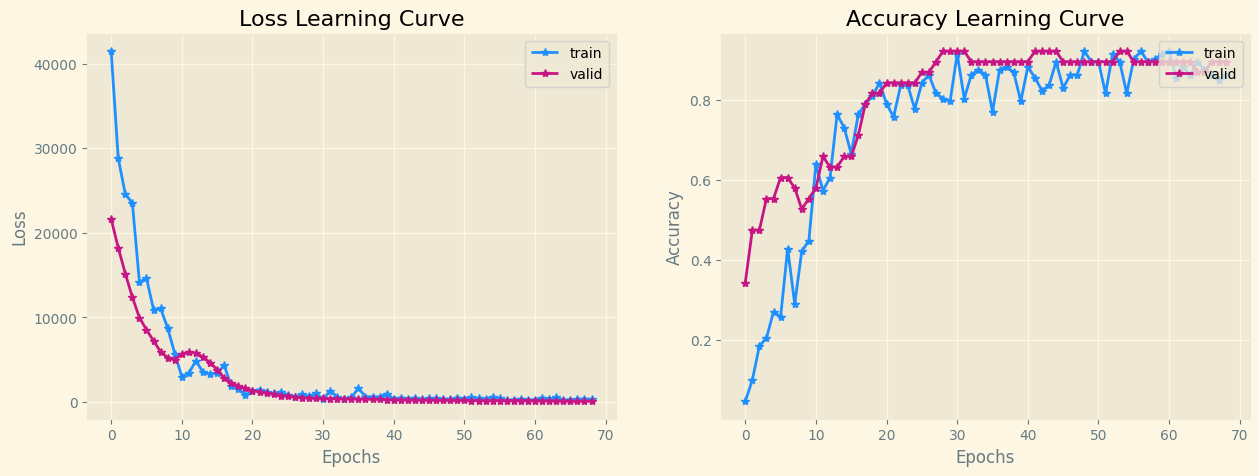

In [90]:
history = train_and_evaluate_GCN(G, nodes_attrs, csr_adj_matrix, edges_attrs, labels)
plot_learning_curves(history)

# Node-Level Task to Predict Children's Grade from Timestamps Hypergraph

This graph was generated by including the data of the two days of measurements. Each node is a child and each edge one single interaction, making this a hypergraph. The relevant nodes attributes are: classroom, grade and gender. Each edge has only one relevant attribute: timesteamp of the interaction.

## Data Pre-Processing

In [91]:
# 1. LOAD THE GRAPH FROM A GML FILE TO NETWORKX
G = nx.read_gml('timestamps_graph.gml', label='id')

# 2. DATA PRE-PROCESSING

scaler = MinMaxScaler() # to normalize continuous values

# [EDGES ATTRIBUTES]

edges_attrs = nx.to_pandas_edgelist(G)

# drop attributes we don't need
edges_attrs = edges_attrs.drop('source', axis=1)
edges_attrs = edges_attrs.drop('target', axis=1)

# normalize continuous values
edges_attrs[['timestamp']] = scaler.fit_transform(edges_attrs[['timestamp']])
print('EDGES ATTRIBUTES:\n')
display(edges_attrs)

# [NODES ATTRIBUTES AND LABELS]

# we make a dataframe for our nodes: each row is a node, each column is an attribute
nodes_attrs = pd.DataFrame(index=G.nodes())
for attr in ['classroom', 'grade', 'gender']:
    nodes_attrs[attr] = pd.Series(nx.get_node_attributes(G, attr))
nodes_attrs = nodes_attrs.sort_index()

# we apply one-hot encoding to our target attribute: grade
nodes_attrs['grade'] = nodes_attrs['grade'].astype('category')
labels = tf.constant(pd.get_dummies(nodes_attrs['grade']).values.astype(np.float32))

# we drop our target attribute from our nodes attributes dataframe
nodes_attrs = nodes_attrs.drop('grade', axis=1)

print('LABELS:\n')
print(labels)

# we apply one-hot encoding to classroom and gender attribues of our nodes attributes dataframe

# one-hot encoding: classroom
classroom_encoded = pd.get_dummies(nodes_attrs['classroom'], prefix='classroom').astype(np.float32)
nodes_attrs = pd.concat([nodes_attrs, classroom_encoded], axis=1)
nodes_attrs = nodes_attrs.drop('classroom', axis=1)

# one-hot encoding: gender
gender_encoded = pd.get_dummies(nodes_attrs['gender'], prefix='gender').astype(np.float32)
nodes_attrs = pd.concat([nodes_attrs, gender_encoded], axis=1)
nodes_attrs = nodes_attrs.drop('gender', axis=1)

print('\nNODES ATTRIBUTES:\n')
display(nodes_attrs)

# WEIGHTED CSR ADJACENCY MATRIX
adj_matrix = np.zeros((len(G), len(G)))
for edge in G.edges:
    node1, node2, weight = edge
    adj_matrix[node1][node2] = float(weight)
    adj_matrix[node2][node1] = float(weight)
csr_adj_matrix = csr_matrix(adj_matrix)
print('WEIGHTED CSR ADJACENCY MATRIX:\n')
print(csr_adj_matrix)

EDGES ATTRIBUTES:



,timestamp
0,0.003422
1,0.003764
2,0.003935
3,0.004106
4,0.004277
...,...
125768,0.797947
125769,0.799487
125770,0.809581
125771,0.967151


LABELS:

tf.Tensor(
[[0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1. 0.]
 ...
 [0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]], shape=(242, 6), dtype=float32)

NODES ATTRIBUTES:



,classroom_1A,classroom_1B,classroom_2A,classroom_2B,classroom_3A,classroom_3B,classroom_4A,classroom_4B,classroom_5A,classroom_5B,classroom_T,gender_F,gender_M,gender_U
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
237,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
238,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
239,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
240,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


WEIGHTED CSR ADJACENCY MATRIX:

  (0, 1)	26.0
  (0, 2)	44.0
  (0, 3)	74.0
  (0, 4)	18.0
  (0, 5)	42.0
  (0, 6)	7.0
  (0, 7)	11.0
  (0, 8)	22.0
  (0, 9)	26.0
  (0, 10)	7.0
  (0, 11)	43.0
  (0, 13)	10.0
  (0, 15)	2.0
  (0, 16)	2.0
  (0, 17)	12.0
  (0, 19)	11.0
  (0, 20)	50.0
  (0, 21)	58.0
  (0, 22)	8.0
  (0, 23)	10.0
  (0, 25)	15.0
  (0, 26)	22.0
  (0, 27)	3.0
  (0, 28)	123.0
  (0, 29)	6.0
  :	:
  (241, 97)	1.0
  (241, 112)	1.0
  (241, 122)	1.0
  (241, 130)	100.0
  (241, 138)	4.0
  (241, 149)	4.0
  (241, 160)	1.0
  (241, 163)	10.0
  (241, 169)	1.0
  (241, 175)	17.0
  (241, 194)	1.0
  (241, 205)	36.0
  (241, 209)	6.0
  (241, 211)	32.0
  (241, 222)	42.0
  (241, 223)	1.0
  (241, 227)	5.0
  (241, 228)	15.0
  (241, 229)	12.0
  (241, 230)	33.0
  (241, 234)	17.0
  (241, 236)	71.0
  (241, 237)	37.0
  (241, 238)	19.0
  (241, 239)	8.0


## GCN Training and Evaluation

Epoch 1/200
1/1 [==============================] - 1s 892ms/step - loss: 245064.5000 - acc: 0.1364 - val_loss: 145676.4375 - val_acc: 0.1538
Epoch 2/200
1/1 [==============================] - 0s 90ms/step - loss: 132694.4688 - acc: 0.2922 - val_loss: 112746.2812 - val_acc: 0.2308
Epoch 3/200
1/1 [==============================] - 0s 63ms/step - loss: 143690.8906 - acc: 0.1883 - val_loss: 88468.8125 - val_acc: 0.3590
Epoch 4/200
1/1 [==============================] - 0s 60ms/step - loss: 149447.7344 - acc: 0.1883 - val_loss: 65021.3398 - val_acc: 0.4615
Epoch 5/200
1/1 [==============================] - 0s 57ms/step - loss: 90930.1484 - acc: 0.4091 - val_loss: 44684.9883 - val_acc: 0.5385
Epoch 6/200
1/1 [==============================] - 0s 57ms/step - loss: 67868.9609 - acc: 0.4675 - val_loss: 27536.9629 - val_acc: 0.5897
Epoch 7/200
1/1 [==============================] - 0s 57ms/step - loss: 53571.4570 - acc: 0.5260 - val_loss: 19314.3906 - val_acc: 0.6667
Epoch 8/200
1/1 [==========

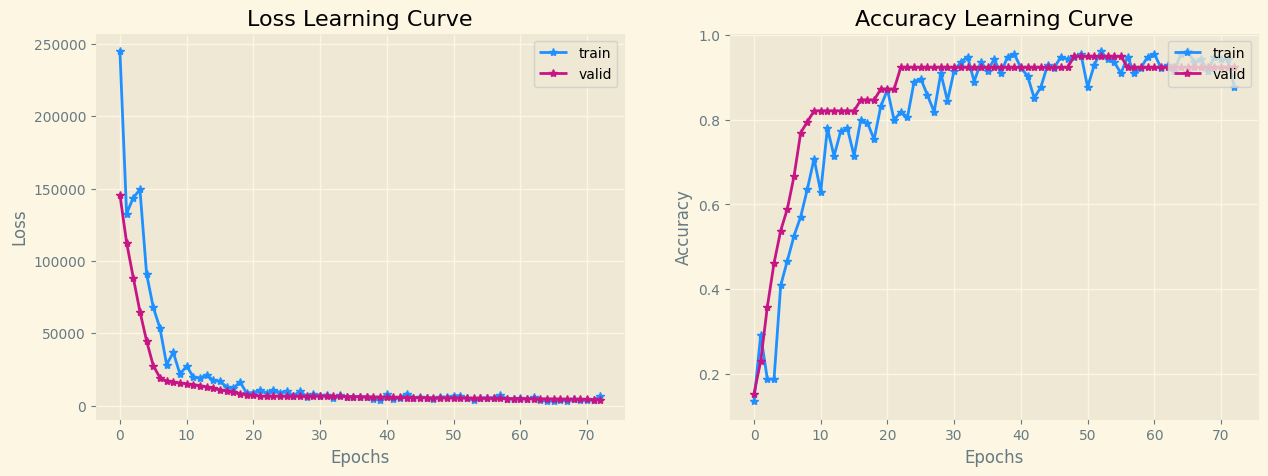

In [92]:
history = train_and_evaluate_GCN(G, nodes_attrs, csr_adj_matrix, edges_attrs, labels)
plot_learning_curves(history)

# Node-Level Task to Predict Children's Classroom from Timestamps Hypergraph

This graph was generated by including the data of the two days of measurements. Each node is a child and each edge one single interaction, making this a hypergraph. The relevant nodes attributes are: classroom, grade and gender. Each edge has only one relevant attribute: timesteamp of the interaction.

## Data Pre-Processing

In [93]:
# 1. LOAD THE GRAPH FROM A GML FILE TO NETWORKX
G = nx.read_gml('timestamps_graph.gml', label='id')

# 2. DATA PRE-PROCESSING

scaler = MinMaxScaler() # to normalize continuous values

# [EDGES ATTRIBUTES]

edges_attrs = nx.to_pandas_edgelist(G)

# drop attributes we don't need
edges_attrs = edges_attrs.drop('source', axis=1)
edges_attrs = edges_attrs.drop('target', axis=1)

# normalize continuous values
edges_attrs[['timestamp']] = scaler.fit_transform(edges_attrs[['timestamp']])
print('EDGES ATTRIBUTES:\n')
display(edges_attrs)

# [NODES ATTRIBUTES AND LABELS]

# we make a dataframe for our nodes: each row is a node, each column is an attribute
nodes_attrs = pd.DataFrame(index=G.nodes())
for attr in ['classroom', 'grade', 'gender']:
    nodes_attrs[attr] = pd.Series(nx.get_node_attributes(G, attr))
nodes_attrs = nodes_attrs.sort_index()

# we apply one-hot encoding to our target attribute: classroom
nodes_attrs['classroom'] = nodes_attrs['classroom'].astype('category')
labels = tf.constant(pd.get_dummies(nodes_attrs['classroom']).values.astype(np.float32))

# we drop our target attribute from our nodes attributes dataframe
nodes_attrs = nodes_attrs.drop('classroom', axis=1)

print('LABELS:\n')
print(labels)

# we apply one-hot encoding to classroom and gender attribues of our nodes attributes dataframe

# one-hot encoding: grade
grade_encoded = pd.get_dummies(nodes_attrs['grade'], prefix='grade').astype(np.float32)
nodes_attrs = pd.concat([nodes_attrs, grade_encoded], axis=1)
nodes_attrs = nodes_attrs.drop('grade', axis=1)

# one-hot encoding: gender
gender_encoded = pd.get_dummies(nodes_attrs['gender'], prefix='gender').astype(np.float32)
nodes_attrs = pd.concat([nodes_attrs, gender_encoded], axis=1)
nodes_attrs = nodes_attrs.drop('gender', axis=1)

print('\nNODES ATTRIBUTES:\n')
display(nodes_attrs)

# WEIGHTED CSR ADJACENCY MATRIX
adj_matrix = np.zeros((len(G), len(G)))
for edge in G.edges:
    node1, node2, weight = edge
    adj_matrix[node1][node2] = float(weight)
    adj_matrix[node2][node1] = float(weight)
csr_adj_matrix = csr_matrix(adj_matrix)
print('WEIGHTED CSR ADJACENCY MATRIX:\n')
print(csr_adj_matrix)

EDGES ATTRIBUTES:



,timestamp
0,0.003422
1,0.003764
2,0.003935
3,0.004106
4,0.004277
...,...
125768,0.797947
125769,0.799487
125770,0.809581
125771,0.967151


LABELS:

tf.Tensor(
[[0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 ...
 [0. 0. 1. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]], shape=(242, 11), dtype=float32)

NODES ATTRIBUTES:



,grade_1,grade_2,grade_3,grade_4,grade_5,grade_T,gender_F,gender_M,gender_U
0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
1,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
3,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...
237,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
238,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
239,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
240,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


WEIGHTED CSR ADJACENCY MATRIX:

  (0, 1)	26.0
  (0, 2)	44.0
  (0, 3)	74.0
  (0, 4)	18.0
  (0, 5)	42.0
  (0, 6)	7.0
  (0, 7)	11.0
  (0, 8)	22.0
  (0, 9)	26.0
  (0, 10)	7.0
  (0, 11)	43.0
  (0, 13)	10.0
  (0, 15)	2.0
  (0, 16)	2.0
  (0, 17)	12.0
  (0, 19)	11.0
  (0, 20)	50.0
  (0, 21)	58.0
  (0, 22)	8.0
  (0, 23)	10.0
  (0, 25)	15.0
  (0, 26)	22.0
  (0, 27)	3.0
  (0, 28)	123.0
  (0, 29)	6.0
  :	:
  (241, 97)	1.0
  (241, 112)	1.0
  (241, 122)	1.0
  (241, 130)	100.0
  (241, 138)	4.0
  (241, 149)	4.0
  (241, 160)	1.0
  (241, 163)	10.0
  (241, 169)	1.0
  (241, 175)	17.0
  (241, 194)	1.0
  (241, 205)	36.0
  (241, 209)	6.0
  (241, 211)	32.0
  (241, 222)	42.0
  (241, 223)	1.0
  (241, 227)	5.0
  (241, 228)	15.0
  (241, 229)	12.0
  (241, 230)	33.0
  (241, 234)	17.0
  (241, 236)	71.0
  (241, 237)	37.0
  (241, 238)	19.0
  (241, 239)	8.0


## GCN Training and Evaluation

Epoch 1/200
1/1 [==============================] - 1s 876ms/step - loss: 489054.4375 - acc: 0.0260 - val_loss: 400476.1250 - val_acc: 0.0000e+00
Epoch 2/200
1/1 [==============================] - 0s 91ms/step - loss: 361181.0938 - acc: 0.0714 - val_loss: 323749.8750 - val_acc: 0.0256
Epoch 3/200
1/1 [==============================] - 0s 58ms/step - loss: 304515.2188 - acc: 0.0844 - val_loss: 263206.5312 - val_acc: 0.2308
Epoch 4/200
1/1 [==============================] - 0s 59ms/step - loss: 333098.4688 - acc: 0.1753 - val_loss: 232419.6250 - val_acc: 0.3333
Epoch 5/200
1/1 [==============================] - 0s 55ms/step - loss: 230306.9219 - acc: 0.2727 - val_loss: 208927.7500 - val_acc: 0.3077
Epoch 6/200
1/1 [==============================] - 0s 86ms/step - loss: 204434.2812 - acc: 0.2338 - val_loss: 187072.8281 - val_acc: 0.3077
Epoch 7/200
1/1 [==============================] - 0s 56ms/step - loss: 184373.0469 - acc: 0.2338 - val_loss: 162371.4219 - val_acc: 0.3077
Epoch 8/200
1/1

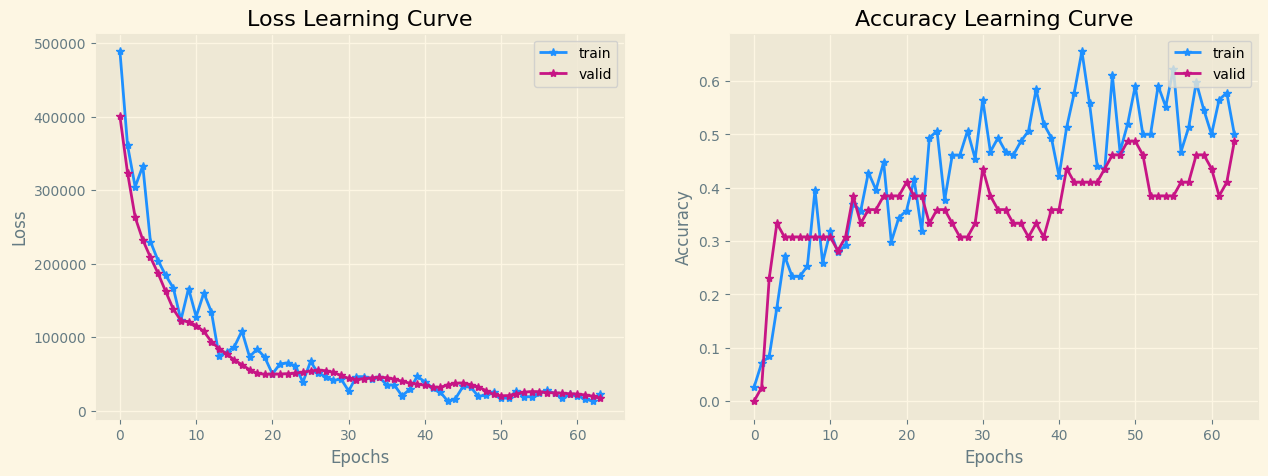

In [95]:
history = train_and_evaluate_GCN(G, nodes_attrs, csr_adj_matrix, edges_attrs, labels)
plot_learning_curves(history)

# Node-Level Task to Predict Children's Communities (6) from Timestamps Hypergraph

This graph was generated by including the data of the two days of measurements. Each node is a child and each edge one single interaction, making this a hypergraph. Then we applied Louvain community detection algorithm with a resolution value fo 1.0 to get 6 communities. The relevant nodes attributes are: classroom, grade, gender and community. Each edge has only one relevant attribute: timesteamp of the interaction.

## Data Pre-Processing

In [103]:
# 1. LOAD THE GRAPH FROM A GML FILE TO NETWORKX
G = nx.read_gml('timestamps_graph_1_6_42.gml', label='id')

# 2. DATA PRE-PROCESSING

scaler = MinMaxScaler() # to normalize continuous values

# [EDGES ATTRIBUTES]

edges_attrs = nx.to_pandas_edgelist(G)

# drop attributes we don't need
edges_attrs = edges_attrs.drop('source', axis=1)
edges_attrs = edges_attrs.drop('target', axis=1)

# normalize continuous values
edges_attrs[['timestamp']] = scaler.fit_transform(edges_attrs[['timestamp']])
print('EDGES ATTRIBUTES:\n')
display(edges_attrs)

# [NODES ATTRIBUTES AND LABELS]

# we make a dataframe for our nodes: each row is a node, each column is an attribute
nodes_attrs = pd.DataFrame(index=G.nodes())
for attr in ['classroom', 'grade', 'gender', 'community']:
    nodes_attrs[attr] = pd.Series(nx.get_node_attributes(G, attr))
nodes_attrs = nodes_attrs.sort_index()

# we apply one-hot encoding to our target attribute: community
nodes_attrs['community'] = nodes_attrs['community'].astype('category')
labels = tf.constant(pd.get_dummies(nodes_attrs['community']).values.astype(np.float32))

# we drop our target attribute from our nodes attributes dataframe
nodes_attrs = nodes_attrs.drop('community', axis=1)

print('LABELS:\n')
print(labels)

# we apply one-hot encoding to classroom and gender attribues of our nodes attributes dataframe

# one-hot encoding: classroom
classroom_encoded = pd.get_dummies(nodes_attrs['classroom'], prefix='classroom').astype(np.float32)
nodes_attrs = pd.concat([nodes_attrs, classroom_encoded], axis=1)
nodes_attrs = nodes_attrs.drop('classroom', axis=1)

# one-hot encoding: grade
grade_encoded = pd.get_dummies(nodes_attrs['grade'], prefix='grade').astype(np.float32)
nodes_attrs = pd.concat([nodes_attrs, grade_encoded], axis=1)
nodes_attrs = nodes_attrs.drop('grade', axis=1)

# one-hot encoding: gender
gender_encoded = pd.get_dummies(nodes_attrs['gender'], prefix='gender').astype(np.float32)
nodes_attrs = pd.concat([nodes_attrs, gender_encoded], axis=1)
nodes_attrs = nodes_attrs.drop('gender', axis=1)

print('\nNODES ATTRIBUTES:\n')
display(nodes_attrs)

# WEIGHTED CSR ADJACENCY MATRIX
for edge in G.edges():
    node1, node2 = edge
    adj_matrix[node1][node2] += 1
    adj_matrix[node2][node1] += 1
csr_adj_matrix = csr_matrix(adj_matrix)
print('WEIGHTED CSR ADJACENCY MATRIX:\n')
print(csr_adj_matrix)

EDGES ATTRIBUTES:



,timestamp
0,0.003422
1,0.003764
2,0.003935
3,0.004106
4,0.004277
...,...
125768,0.788195
125769,0.789222
125770,0.789393
125771,0.800855


LABELS:

tf.Tensor(
[[1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 ...
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 1.]], shape=(242, 6), dtype=float32)

NODES ATTRIBUTES:



,classroom_1A,classroom_1B,classroom_2A,classroom_2B,classroom_3A,classroom_3B,classroom_4A,classroom_4B,classroom_5A,classroom_5B,classroom_T,grade_1,grade_2,grade_3,grade_4,grade_5,grade_T,gender_F,gender_M,gender_U
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
237,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
238,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
239,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
240,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0


WEIGHTED CSR ADJACENCY MATRIX:

  (0, 1)	28.0
  (0, 2)	46.0
  (0, 3)	76.0
  (0, 4)	20.0
  (0, 5)	44.0
  (0, 6)	9.0
  (0, 7)	13.0
  (0, 8)	24.0
  (0, 9)	28.0
  (0, 10)	9.0
  (0, 11)	45.0
  (0, 12)	2.0
  (0, 13)	12.0
  (0, 15)	4.0
  (0, 16)	4.0
  (0, 17)	14.0
  (0, 19)	13.0
  (0, 20)	52.0
  (0, 21)	60.0
  (0, 22)	13.0
  (0, 23)	12.0
  (0, 25)	4.0
  (0, 26)	24.0
  (0, 27)	5.0
  (0, 28)	125.0
  :	:
  (241, 211)	2.0
  (241, 213)	9.0
  (241, 215)	12.0
  (241, 216)	34.0
  (241, 217)	32.0
  (241, 218)	23.0
  (241, 219)	2.0
  (241, 220)	2.0
  (241, 221)	16.0
  (241, 222)	25.0
  (241, 223)	7.0
  (241, 224)	3.0
  (241, 225)	74.0
  (241, 226)	12.0
  (241, 227)	8.0
  (241, 228)	95.0
  (241, 229)	2.0
  (241, 230)	20.0
  (241, 231)	13.0
  (241, 232)	28.0
  (241, 235)	9.0
  (241, 237)	23.0
  (241, 238)	23.0
  (241, 239)	17.0
  (241, 240)	17.0


## GCN Training and Evaluation

Epoch 1/200
1/1 [==============================] - 1s 1s/step - loss: 545103.1875 - acc: 0.1234 - val_loss: 289473.8438 - val_acc: 0.2564
Epoch 2/200
1/1 [==============================] - 0s 64ms/step - loss: 325546.4375 - acc: 0.0390 - val_loss: 214574.9844 - val_acc: 0.2821
Epoch 3/200
1/1 [==============================] - 0s 64ms/step - loss: 295371.0000 - acc: 0.1494 - val_loss: 149713.5156 - val_acc: 0.2051
Epoch 4/200
1/1 [==============================] - 0s 94ms/step - loss: 231171.4219 - acc: 0.1494 - val_loss: 101105.7266 - val_acc: 0.1795
Epoch 5/200
1/1 [==============================] - 0s 60ms/step - loss: 175531.3438 - acc: 0.1558 - val_loss: 75970.5391 - val_acc: 0.3333
Epoch 6/200
1/1 [==============================] - 0s 64ms/step - loss: 150563.9219 - acc: 0.1688 - val_loss: 60750.1211 - val_acc: 0.3333
Epoch 7/200
1/1 [==============================] - 0s 63ms/step - loss: 106873.0078 - acc: 0.2922 - val_loss: 42329.5898 - val_acc: 0.3846
Epoch 8/200
1/1 [========

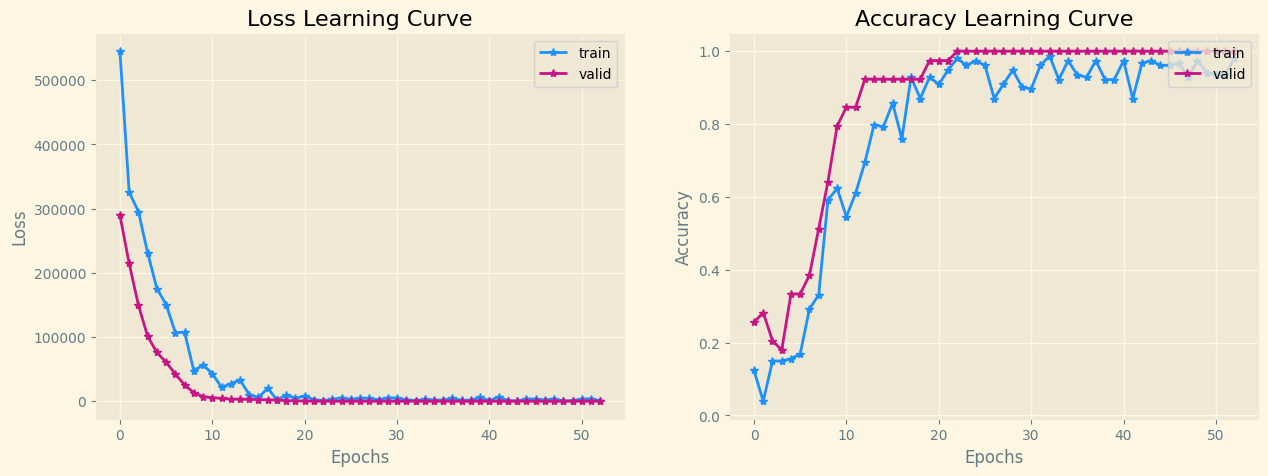

In [104]:
history = train_and_evaluate_GCN(G, nodes_attrs, csr_adj_matrix, edges_attrs, labels)
plot_learning_curves(history)

# Node-Level Task to Predict Children's Communities (10) from Timestamps Hypergraph

This graph was generated by including the data of the two days of measurements. Each node is a child and each edge one single interaction, making this a hypergraph. Then we applied Louvain community detection algorithm with a resolution value fo 2.0 to get 10 communities. The relevant nodes attributes are: classroom, grade, gender and community. Each edge has only one relevant attribute: timesteamp of the interaction.

## Data Pre-Processing

In [105]:
# 1. LOAD THE GRAPH FROM A GML FILE TO NETWORKX
G = nx.read_gml('timestamps_graph_2_10_42.gml', label='id')

# 2. DATA PRE-PROCESSING

scaler = MinMaxScaler() # to normalize continuous values

# [EDGES ATTRIBUTES]

edges_attrs = nx.to_pandas_edgelist(G)

# drop attributes we don't need
edges_attrs = edges_attrs.drop('source', axis=1)
edges_attrs = edges_attrs.drop('target', axis=1)

# normalize continuous values
edges_attrs[['timestamp']] = scaler.fit_transform(edges_attrs[['timestamp']])
print('EDGES ATTRIBUTES:\n')
display(edges_attrs)

# [NODES ATTRIBUTES AND LABELS]

# we make a dataframe for our nodes: each row is a node, each column is an attribute
nodes_attrs = pd.DataFrame(index=G.nodes())
for attr in ['classroom', 'grade', 'gender', 'community']:
    nodes_attrs[attr] = pd.Series(nx.get_node_attributes(G, attr))
nodes_attrs = nodes_attrs.sort_index()

# we apply one-hot encoding to our target attribute: community
nodes_attrs['community'] = nodes_attrs['community'].astype('category')
labels = tf.constant(pd.get_dummies(nodes_attrs['community']).values.astype(np.float32))

# we drop our target attribute from our nodes attributes dataframe
nodes_attrs = nodes_attrs.drop('community', axis=1)

print('LABELS:\n')
print(labels)

# we apply one-hot encoding to classroom and gender attribues of our nodes attributes dataframe

# one-hot encoding: classroom
classroom_encoded = pd.get_dummies(nodes_attrs['classroom'], prefix='classroom').astype(np.float32)
nodes_attrs = pd.concat([nodes_attrs, classroom_encoded], axis=1)
nodes_attrs = nodes_attrs.drop('classroom', axis=1)

# one-hot encoding: grade
grade_encoded = pd.get_dummies(nodes_attrs['grade'], prefix='grade').astype(np.float32)
nodes_attrs = pd.concat([nodes_attrs, grade_encoded], axis=1)
nodes_attrs = nodes_attrs.drop('grade', axis=1)

# one-hot encoding: gender
gender_encoded = pd.get_dummies(nodes_attrs['gender'], prefix='gender').astype(np.float32)
nodes_attrs = pd.concat([nodes_attrs, gender_encoded], axis=1)
nodes_attrs = nodes_attrs.drop('gender', axis=1)

print('\nNODES ATTRIBUTES:\n')
display(nodes_attrs)

# WEIGHTED CSR ADJACENCY MATRIX
for edge in G.edges():
    node1, node2 = edge
    adj_matrix[node1][node2] += 1
    adj_matrix[node2][node1] += 1
csr_adj_matrix = csr_matrix(adj_matrix)
print('WEIGHTED CSR ADJACENCY MATRIX:\n')
print(csr_adj_matrix)

EDGES ATTRIBUTES:



,timestamp
0,0.003422
1,0.003764
2,0.003935
3,0.004106
4,0.004277
...,...
125768,0.785115
125769,0.797947
125770,0.799487
125771,0.809581


LABELS:

tf.Tensor(
[[1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]], shape=(242, 10), dtype=float32)

NODES ATTRIBUTES:



,classroom_1A,classroom_1B,classroom_2A,classroom_2B,classroom_3A,classroom_3B,classroom_4A,classroom_4B,classroom_5A,classroom_5B,classroom_T,grade_1,grade_2,grade_3,grade_4,grade_5,grade_T,gender_F,gender_M,gender_U
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
237,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
238,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
239,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
240,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


WEIGHTED CSR ADJACENCY MATRIX:

  (0, 1)	73.0
  (0, 2)	58.0
  (0, 3)	84.0
  (0, 4)	21.0
  (0, 5)	55.0
  (0, 6)	9.0
  (0, 7)	16.0
  (0, 8)	27.0
  (0, 9)	41.0
  (0, 10)	9.0
  (0, 11)	96.0
  (0, 12)	61.0
  (0, 13)	24.0
  (0, 14)	11.0
  (0, 15)	7.0
  (0, 16)	4.0
  (0, 17)	37.0
  (0, 18)	4.0
  (0, 19)	137.0
  (0, 20)	55.0
  (0, 21)	60.0
  (0, 22)	71.0
  (0, 23)	17.0
  (0, 24)	4.0
  (0, 25)	15.0
  :	:
  (241, 216)	34.0
  (241, 217)	34.0
  (241, 218)	23.0
  (241, 219)	2.0
  (241, 220)	195.0
  (241, 221)	127.0
  (241, 222)	41.0
  (241, 223)	44.0
  (241, 224)	15.0
  (241, 225)	74.0
  (241, 226)	40.0
  (241, 227)	17.0
  (241, 228)	165.0
  (241, 229)	21.0
  (241, 230)	72.0
  (241, 231)	41.0
  (241, 232)	45.0
  (241, 233)	16.0
  (241, 234)	13.0
  (241, 235)	43.0
  (241, 236)	18.0
  (241, 237)	95.0
  (241, 238)	61.0
  (241, 239)	37.0
  (241, 240)	26.0


## GCN Training and Evaluation

Epoch 1/200
1/1 [==============================] - 1s 936ms/step - loss: 1384227.1250 - acc: 0.0325 - val_loss: 1378485.2500 - val_acc: 0.0513
Epoch 2/200
1/1 [==============================] - 0s 92ms/step - loss: 1011013.0625 - acc: 0.0779 - val_loss: 1030381.0625 - val_acc: 0.0513
Epoch 3/200
1/1 [==============================] - 0s 67ms/step - loss: 818707.7500 - acc: 0.1364 - val_loss: 736920.1250 - val_acc: 0.0513
Epoch 4/200
1/1 [==============================] - 0s 74ms/step - loss: 581726.5000 - acc: 0.1234 - val_loss: 545025.0000 - val_acc: 0.2051
Epoch 5/200
1/1 [==============================] - 0s 68ms/step - loss: 673179.6250 - acc: 0.1494 - val_loss: 450129.9375 - val_acc: 0.2564
Epoch 6/200
1/1 [==============================] - 0s 70ms/step - loss: 452435.5312 - acc: 0.1234 - val_loss: 389566.4375 - val_acc: 0.3077
Epoch 7/200
1/1 [==============================] - 0s 75ms/step - loss: 461202.9688 - acc: 0.2468 - val_loss: 328255.3125 - val_acc: 0.3077
Epoch 8/200
1/1

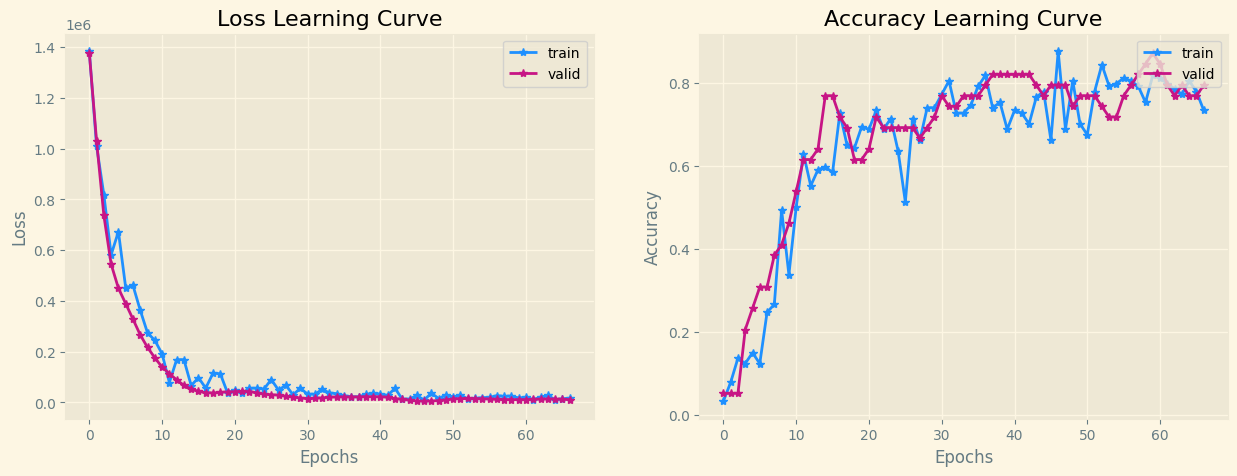

In [106]:
history = train_and_evaluate_GCN(G, nodes_attrs, csr_adj_matrix, edges_attrs, labels)
plot_learning_curves(history)